In [1]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import resnet
from custom_datasets import CIFAR10C
from trainer import AverageMeter, model_names
import numpy as np

['resnet110', 'resnet1202', 'resnet20', 'resnet32', 'resnet44', 'resnet56']


In [2]:
model = torch.nn.DataParallel(resnet.__dict__['resnet20']())

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [3]:
run_name = "xent_ls0._seed1"
checkpoint_name = "data/"+run_name+"/checkpoint.th"
model.cuda()

print("=> loading checkpoint '{}'".format(checkpoint_name))
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'data/xent_ls0._seed1/checkpoint.th'


<All keys matched successfully>

In [4]:

def validate(val_loader, model):
    # switch to evaluate mode
    model.eval()


    accuracy = AverageMeter()
    output_entropy = AverageMeter()

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input_var = input.cuda()
            # target_var = target.cuda()
            # one_hot = nn.functional.one_hot(target_var.to(torch.int64), 10)

            output = model(input_var)
            output = output.float()
            output_entropy.update(-torch.mean(torch.sum(torch.nn.functional.softmax(output, dim=1) * torch.nn.functional.log_softmax(output, dim=1), dim=1)), len(output))

            accuracy_batch = torch.mean(torch.eq(torch.argmax(output, dim=1), target.cuda()).float())
            accuracy.update(accuracy_batch, len(output))

    return accuracy.avg.item(), output_entropy.avg.item()


In [5]:
outputs_all = []


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

for corruption_type in ["impulse_noise", "defocus_blur", "motion_blur", "shot_noise", "speckle_noise"]:
    valc_loaders = []
    for corruption_level in range(5):
        valc_loader = torch.utils.data.DataLoader(
            CIFAR10C(corruption_type, corruption_level, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=128, shuffle=False,
            num_workers=4, pin_memory=True)
        valc_loaders.append(valc_loader)

    outputs_per_corruption = []
    for valc_loader in valc_loaders:
        output = validate(valc_loader, model)
        outputs_per_corruption.append(list(output))
    outputs_all.append(outputs_per_corruption)

In [7]:
outputs_all = np.array(outputs_all)

In [8]:
outputs_all.shape

(5, 5, 2)

Text(0, 0.5, 'Entropy')

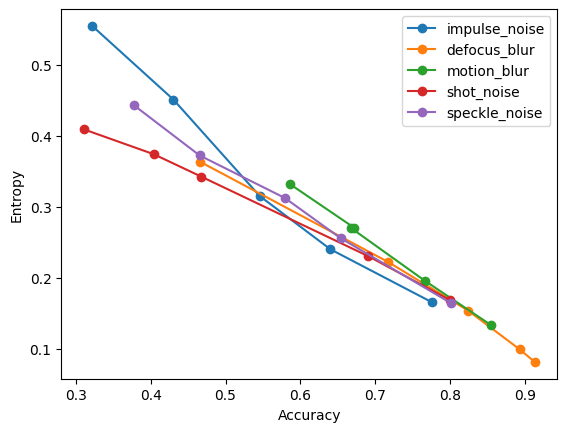

In [14]:
import matplotlib.pyplot as plt
corruption_types = ["impulse_noise", "defocus_blur", "motion_blur", "shot_noise", "speckle_noise"]
for i in range(5):
    plt.plot(outputs_all[i, :, 0], outputs_all[i, :, 1], "o-", label=corruption_types[i])
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Entropy")